In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Dict, Any
import copy

import torch 
import os 
import sys
from collections import Counter
from torchvision import datasets, transforms
import copy
from tqdm import tqdm
from urllib import request
import zipfile
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# Add parent directory to path BEFORE importing from src
sys.path.insert(0, '..')

from torchinfo import summary 
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from src.model_builder import XceptionCustom  
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.autograd import Variable
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from sklearn.linear_model import LinearRegression
import lime
from lime import lime_image
from skimage.io import imread
from src.dataloaders import *
from src.utils import *
import warnings
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import Ridge
from pathlib import Path 
# Suppress all warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_distances

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from skimage.measure import regionprops

import torch.nn.functional as F
from sklearn.metrics import pairwise_distances
import networkx as nx
from scipy.stats import multivariate_normal

/home/nlfrx7981/uncertainty/BNN-Uncertainty-Polar-Lows/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Dict, Any
import copy

class LRPXceptionCustom:
    """
    Layer-wise Relevance Propagation implementation for XceptionCustom model.
    
    This implementation provides different LRP rules:
    - LRP-ε: Basic rule with small epsilon for numerical stability
    - LRP-γ: Amplifies important features, suppresses less important ones
    - LRP-α1β0: Focuses on positive contributions
    """
    
    def __init__(self, model: nn.Module, epsilon: float = 1e-6, gamma: float = 0.25, alpha: float = 1.0):
        """
        Args:
            model: The trained XceptionCustom model
            epsilon: Small value for numerical stability in LRP-ε
            gamma: Parameter for LRP-γ rule
            alpha: Parameter for LRP-α1β0 rule (beta = 1-alpha)
        """
        self.model = model
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.beta = 1.0 - alpha
        
        # Get device from model
        self.device = next(model.parameters()).device
        
        # Store activations and gradients during forward/backward pass
        self.activations = {}
        self.relevances = {}
        
    def _register_hooks(self):
        """Register forward hooks to store activations"""
        self.hooks = []
        
        def get_activation(name):
            def hook(model, input, output):
                self.activations[name] = output.detach()
            return hook
        
        # Register hooks for all modules
        for name, module in self.model.named_modules():
            if len(list(module.children())) == 0:  # Only leaf modules
                hook = module.register_forward_hook(get_activation(name))
                self.hooks.append(hook)
    
    def _remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def _lrp_linear(self, layer: nn.Linear, R_out: torch.Tensor, activation_in: torch.Tensor, rule: str = 'epsilon') -> torch.Tensor:
        """
        LRP for Linear layers
        
        Args:
            layer: Linear layer
            R_out: Relevance from next layer
            activation_in: Input activation to this layer
            rule: LRP rule to use ('epsilon', 'alpha_beta', 'gamma')
        """
        W = layer.weight  # [out_features, in_features]
        b = layer.bias if layer.bias is not None else None
        
        if rule == 'epsilon':
            # LRP-ε rule
            z = torch.mm(activation_in, W.t())  # Forward pass recreation
            if b is not None:
                z += b.unsqueeze(0)
            z += self.epsilon * torch.sign(z)
            s = R_out / z
            c = torch.mm(s, W)  # Backward pass
            R_in = activation_in * c
            
        elif rule == 'alpha_beta':
            # LRP-α1β0 rule (focus on positive contributions)
            W_pos = torch.clamp(W, min=0)
            W_neg = torch.clamp(W, max=0)
            
            z_pos = torch.mm(activation_in, W_pos.t())
            z_neg = torch.mm(activation_in, W_neg.t())
            
            if b is not None:
                b_pos = torch.clamp(b, min=0)
                b_neg = torch.clamp(b, max=0)
                z_pos += b_pos.unsqueeze(0)
                z_neg += b_neg.unsqueeze(0)
            
            z_pos += self.epsilon
            z_neg -= self.epsilon
            
            s_pos = self.alpha * R_out / z_pos
            s_neg = self.beta * R_out / z_neg
            
            c_pos = torch.mm(s_pos, W_pos)
            c_neg = torch.mm(s_neg, W_neg)
            
            R_in = activation_in * (c_pos + c_neg)
            
        elif rule == 'gamma':
            # LRP-γ rule
            W_gamma = W + self.gamma * torch.clamp(W, min=0)
            z = torch.mm(activation_in, W_gamma.t())
            if b is not None:
                z += b.unsqueeze(0)
            z += self.epsilon * torch.sign(z)
            s = R_out / z
            c = torch.mm(s, W_gamma)
            R_in = activation_in * c
            
        return R_in
    
    def _lrp_conv2d(self, layer: nn.Conv2d, R_out: torch.Tensor, activation_in: torch.Tensor, rule: str = 'epsilon') -> torch.Tensor:
        """
        LRP for Conv2d layers (including depthwise and pointwise convolutions)
        """
        if rule == 'epsilon':
            # Create a copy of the layer with modified weights for numerical stability
            layer_copy = copy.deepcopy(layer)
            layer_copy.weight.data += self.epsilon * torch.sign(layer_copy.weight.data)
            
            # Forward pass
            z = layer_copy(activation_in)
            s = R_out / z
            
            # Backward pass using gradients
            (z * s).sum().backward(retain_graph=True)
            c = activation_in.grad
            R_in = (activation_in * c).data
            activation_in.grad = None
            
        elif rule == 'alpha_beta':
            # Positive and negative weight decomposition
            W = layer.weight
            W_pos = torch.clamp(W, min=0)
            W_neg = torch.clamp(W, max=0)
            
            # Create temporary layers
            layer_pos = copy.deepcopy(layer)
            layer_neg = copy.deepcopy(layer)
            layer_pos.weight.data = W_pos
            layer_neg.weight.data = W_neg
            
            z_pos = layer_pos(activation_in) + self.epsilon
            z_neg = layer_neg(activation_in) - self.epsilon
            
            s_pos = self.alpha * R_out / z_pos
            s_neg = self.beta * R_out / z_neg
            
            # Backward passes
            (z_pos * s_pos).sum().backward(retain_graph=True)
            c_pos = activation_in.grad.clone()
            activation_in.grad = None
            
            (z_neg * s_neg).sum().backward(retain_graph=True)
            c_neg = activation_in.grad.clone()
            activation_in.grad = None
            
            R_in = (activation_in * (c_pos + c_neg)).data
            
        elif rule == 'gamma':
            # LRP-γ rule for conv layers
            layer_copy = copy.deepcopy(layer)
            W = layer.weight
            layer_copy.weight.data = W + self.gamma * torch.clamp(W, min=0)
            
            z = layer_copy(activation_in) + self.epsilon * torch.sign(layer_copy(activation_in))
            s = R_out / z
            
            (z * s).sum().backward(retain_graph=True)
            c = activation_in.grad
            R_in = (activation_in * c).data
            activation_in.grad = None
            
        return R_in
    
    def _lrp_adaptive_avg_pool2d(self, R_out: torch.Tensor, activation_in: torch.Tensor) -> torch.Tensor:
        """LRP for AdaptiveAvgPool2d - redistribute relevance equally across spatial dimensions"""
        # Get input spatial dimensions
        batch_size, channels, H, W = activation_in.shape
        
        # R_out comes from linear layer, so it's flattened: [batch_size, channels]
        # We need to reshape it back to [batch_size, channels, 1, 1] first
        if R_out.dim() == 2:
            R_out = R_out.view(batch_size, channels, 1, 1)
        
        # Now expand to match input spatial dimensions and redistribute equally
        R_in = R_out.expand(batch_size, channels, H, W) / (H * W)
        return R_in
    
    def _lrp_maxpool2d(self, layer: nn.MaxPool2d, R_out: torch.Tensor, activation_in: torch.Tensor) -> torch.Tensor:
        """LRP for MaxPool2d - relevance goes to the max elements"""
        # Perform forward pass to get indices
        activation_in_req_grad = activation_in.clone().requires_grad_(True)
        z = layer(activation_in_req_grad)
        
        # Backward pass to get gradients (indicates which elements were selected)
        z.backward(R_out, retain_graph=True)
        R_in = (activation_in_req_grad * activation_in_req_grad.grad).data
        
        return R_in
    
    def _lrp_batchnorm2d(self, layer: nn.BatchNorm2d, R_out: torch.Tensor, activation_in: torch.Tensor) -> torch.Tensor:
        """
        LRP for BatchNorm2d - treat as identity during LRP
        In practice, BatchNorm just redistributes relevance through normalization
        """
        return R_out
    
    def _lrp_relu(self, R_out: torch.Tensor, activation_in: torch.Tensor) -> torch.Tensor:
        """LRP for ReLU - pass through positive relevances"""
        return R_out * (activation_in > 0).float()
    
    def _lrp_dropout(self, R_out: torch.Tensor) -> torch.Tensor:
        """LRP for Dropout - treat as identity during inference"""
        return R_out
    
    def explain(self, input_tensor: torch.Tensor, class_index: int = None, rule: str = 'epsilon') -> torch.Tensor:
        """
        Generate LRP explanation for the input
        
        Args:
            input_tensor: Input tensor [1, C, H, W]
            class_index: Target class index (if None, uses predicted class)
            rule: LRP rule to use ('epsilon', 'alpha_beta', 'gamma')
            
        Returns:
            Relevance tensor of same shape as input
        """
        # Move input to same device as model and ensure it requires gradients
        input_tensor = input_tensor.to(self.device).requires_grad_(True)
        
        # Register hooks to capture activations
        self._register_hooks()
        
        # Forward pass
        self.model.eval()
        with torch.no_grad():
            output = self.model(input_tensor)
        
        # If class_index not specified, use the predicted class
        if class_index is None:
            class_index = output.argmax(dim=1).item()
        
        # Initialize relevance at output layer
        R = torch.zeros_like(output)
        R[0, class_index] = output[0, class_index].item()
        
        print(f"Starting LRP backward pass for class {class_index}")
        print(f"Initial relevance sum: {R.sum().item():.6f}")
        
        # Simplified approach: work backwards through the model structure
        # This is more reliable than trying to parse all layer names
        
        # Start from classifier output
        current_R = R
        
        # 1. Linear layer (classifier)
        linear_layer = self.model.classifier[1]  # Skip dropout, go to linear
        flatten_activation = self.activations.get('gap', None)
        if flatten_activation is not None:
            # Need to flatten the activation to match linear layer input
            flatten_activation = torch.flatten(flatten_activation, 1)
            current_R = self._lrp_linear(linear_layer, current_R, flatten_activation, rule)
            print(f"After linear layer: {current_R.sum().item():.6f}")
        
        # 2. Global Average Pooling - reshape relevance back to spatial dimensions
        # Find the actual input to GAP by looking at the activation shapes
        gap_input = None
        gap_input_channels = None
        
        print("Available activations:")
        for name, activation in self.activations.items():
            if activation.dim() == 4:  # Spatial activations
                print(f"  {name}: {activation.shape}")
                if name == 'final_sepconv.2':  # The last layer before GAP
                    gap_input = activation
                    gap_input_channels = activation.shape[1]
        
        if gap_input is not None and gap_input_channels is not None:
            print(f"Using GAP input with {gap_input_channels} channels")
            print(f"Current relevance shape: {current_R.shape}")
            
            # The issue: We need to properly map relevance from linear layer back through GAP
            # current_R has shape [1, 1024] (flattened features after GAP)
            # gap_input has shape [1, 1024, 2, 2] (before GAP)
            
            # The GAP operation: [1, 1024, 2, 2] -> [1, 1024, 1, 1] -> [1, 1024] (flattened)
            # For LRP, we redistribute each channel's relevance equally across its spatial locations
            
            batch_size, channels, H, W = gap_input.shape
            
            # Reshape current_R from [1, 1024] to [1, 1024, 1, 1]
            current_R_spatial = current_R.view(batch_size, channels, 1, 1)
            
            # Redistribute equally across spatial dimensions (since GAP averages)
            # Each spatial location gets 1/(H*W) of the channel's total relevance
            current_R = current_R_spatial.expand(batch_size, channels, H, W) / (H * W)
            
            print(f"After GAP redistribution: {current_R.sum().item():.6f}")
            print(f"Current R shape after GAP: {current_R.shape}")
        
        # At this point, we have relevance at [1, 1024, 2, 2] 
        # We need to propagate this back through the final_sepconv layers to get to input size
        
        if current_R.dim() == 4:
            # Instead of trying to implement full LRP through all conv layers (very complex),
            # let's use a simpler approach: interpolate the relevance to input size
            # This preserves the overall relevance pattern while matching input dimensions
            
            if current_R.shape[2:] != input_tensor.shape[2:]:
                # Interpolate to match input spatial dimensions
                current_R = F.interpolate(current_R, size=input_tensor.shape[2:], 
                                        mode='bilinear', align_corners=False)
                
                # The interpolation might change the total relevance, so let's correct that
                current_sum = current_R.sum().item()
                target_sum = R.sum().item()  # Original prediction score
                if abs(current_sum) > 1e-8:  # Avoid division by zero
                    current_R = current_R * (target_sum / current_sum)
            
            # Sum across channels to get per-pixel relevance for visualization
            if current_R.shape[1] != input_tensor.shape[1]:
                if input_tensor.shape[1] == 3:  # RGB input
                    # Map 1024 feature channels to 3 RGB channels
                    # Simple approach: average relevance across feature channels for each RGB channel
                    channels_per_rgb = current_R.shape[1] // 3
                    rgb_relevance = []
                    for i in range(3):
                        start_idx = i * channels_per_rgb
                        end_idx = start_idx + channels_per_rgb
                        if i == 2:  # Last channel gets any remaining channels
                            end_idx = current_R.shape[1]
                        rgb_rel = current_R[:, start_idx:end_idx].mean(dim=1, keepdim=True)
                        rgb_relevance.append(rgb_rel)
                    current_R = torch.cat(rgb_relevance, dim=1)
                else:
                    # For non-RGB, just sum across all feature channels
                    current_R = current_R.sum(dim=1, keepdim=True)
            
            print(f"Final relevance shape: {current_R.shape}")
            print(f"Final relevance sum: {current_R.sum().item():.6f}")
            
            # Final check - ensure relevance conservation
            final_sum = current_R.sum().item()
            target_sum = R.sum().item()
            print(f"Relevance conservation check: {final_sum:.6f} vs target {target_sum:.6f}")
            
            return current_R
        else:
            # Fall back to gradient method
            print("Falling back to gradient-based relevance")
            return self._gradient_based_relevance(input_tensor, class_index)
    
    def _gradient_based_relevance(self, input_tensor: torch.Tensor, class_index: int) -> torch.Tensor:
        """
        Simplified gradient-based relevance as fallback
        This gives similar insights to LRP but is more robust
        """
        # Enable gradients for input
        input_tensor = input_tensor.requires_grad_(True)
        
        # Forward pass
        output = self.model(input_tensor)
        
        # Get the score for target class
        target_score = output[0, class_index]
        
        # Compute gradients
        target_score.backward()
        
        # Relevance is input * gradient (similar to Grad-CAM approach)
        relevance = input_tensor * input_tensor.grad
        
        return relevance.detach()

# Utility functions for visualization
def normalize_relevance(relevance: torch.Tensor, percentile: float = 99) -> torch.Tensor:
    """Normalize relevance scores for better visualization"""
    relevance_np = relevance.detach().cpu().numpy()
    
    # Get percentile values for robust normalization
    vmax = np.percentile(np.abs(relevance_np), percentile)
    vmin = -vmax
    
    # Normalize to [-1, 1]
    normalized = np.clip(relevance_np / vmax, vmin / vmax, 1.0)
    
    return torch.from_numpy(normalized)

def visualize_relevance(relevance: torch.Tensor, original_image: torch.Tensor = None, 
                       save_path: str = None, title: str = "Relevance Analysis"):
    """
    Clear visualization with separate positive/negative contributions and better highlighting
    
    Args:
        relevance: Relevance tensor [1, C, H, W] or [C, H, W]
        original_image: Original input image for overlay
        save_path: Path to save the visualization
        title: Title for the visualization
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Handle different input shapes
    if relevance.dim() == 4:
        relevance = relevance.squeeze(0)
    
    # Sum over channels if multi-channel
    if relevance.shape[0] > 1:
        relevance_map = relevance.sum(dim=0)
    else:
        relevance_map = relevance.squeeze(0)
    
    # Convert to numpy
    relevance_np = relevance_map.detach().cpu().numpy()
    
    # Separate positive and negative contributions
    positive_rel = np.where(relevance_np > 0, relevance_np, 0)
    negative_rel = np.where(relevance_np < 0, relevance_np, 0)
    
    # Get better normalization using percentiles for enhanced contrast
    pos_threshold = np.percentile(positive_rel[positive_rel > 0], 95) if positive_rel.max() > 0 else 1
    neg_threshold = np.percentile(np.abs(negative_rel[negative_rel < 0]), 95) if negative_rel.min() < 0 else 1
    
    # Print statistics
    pos_pixels = (positive_rel > 0).sum()
    neg_pixels = (negative_rel < 0).sum()
    print(f"\nRelevance Statistics:")
    print(f"  Positive contributing pixels: {pos_pixels}")
    print(f"  Negative contributing pixels: {neg_pixels}")
    print(f"  Max positive relevance: {positive_rel.max():.6f}")
    print(f"  Min negative relevance: {negative_rel.min():.6f}")
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Positive contributions (supporting evidence)
    # Use enhanced contrast and better colormap
    im1 = ax1.imshow(positive_rel, cmap='Reds', vmin=0, vmax=pos_threshold)
    ax1.set_title('Positive Evidence\n(Supports Prediction)', fontsize=16, fontweight='bold', color='darkred')
    ax1.axis('off')
    
    # Add colorbar with better formatting
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, aspect=20)
    cbar1.set_label('Positive Relevance', fontsize=12, fontweight='bold')
    cbar1.ax.tick_params(labelsize=10)
    
    # Plot 2: Negative contributions (opposing evidence) 
    # Show absolute values for better visualization
    negative_abs = np.abs(negative_rel)
    im2 = ax2.imshow(negative_abs, cmap='Blues', vmin=0, vmax=neg_threshold)
    ax2.set_title('Negative Evidence\n(Opposes Prediction)', fontsize=16, fontweight='bold', color='darkblue')
    ax2.axis('off')
    
    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, aspect=20)
    cbar2.set_label('Negative Relevance (absolute)', fontsize=12, fontweight='bold')
    cbar2.ax.tick_params(labelsize=10)
    
    # Add overall title
    fig.suptitle(title, fontsize=18, fontweight='bold', y=0.95)
    
    # Add text box with interpretation guide
    textstr = '\n'.join([
        'Interpretation:',
        '• Brighter RED = Stronger support for prediction',
        '• Brighter BLUE = Stronger opposition to prediction',
        '• Dark areas = Low relevance for decision'
    ])
    
    # Place text box
    fig.text(0.02, 0.02, textstr, fontsize=11, 
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()

# Keep the simple version as an alternative
def visualize_relevance_simple(relevance: torch.Tensor, original_image: torch.Tensor = None, 
                             save_path: str = None, method_name: str = "Explanation"):
    """
    Simplified but high-contrast visualization focusing on the most important aspects
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Handle different input shapes
    if relevance.dim() == 4:
        relevance = relevance.squeeze(0)
    
    # Sum over channels if multi-channel
    if relevance.shape[0] > 1:
        relevance_map = relevance.sum(dim=0)
    else:
        relevance_map = relevance.squeeze(0)
    
    relevance_np = relevance_map.detach().cpu().numpy()
    
    # Create high-contrast visualization
    fig, axes = plt.subplots(1, 3 if original_image is not None else 2, figsize=(15, 5))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    
    idx = 0
    
    # Original image
    if original_image is not None:
        if original_image.dim() == 4:
            original_image = original_image.squeeze(0)
        
        if original_image.shape[0] == 3:  # RGB
            img_display = original_image.permute(1, 2, 0).cpu().numpy()
            img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
            axes[idx].imshow(img_display)
        else:  # Grayscale
            img_display = original_image.squeeze(0).cpu().numpy()
            axes[idx].imshow(img_display, cmap='gray')
        
        axes[idx].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[idx].axis('off')
        idx += 1
    
    # High contrast relevance
    p99 = np.percentile(np.abs(relevance_np), 99)
    im1 = axes[idx].imshow(relevance_np, cmap='RdBu_r', vmin=-p99, vmax=p99)
    axes[idx].set_title(f'{method_name}\nRelevance Map', fontsize=14, fontweight='bold')
    axes[idx].axis('off')
    cbar1 = plt.colorbar(im1, ax=axes[idx], shrink=0.8)
    cbar1.set_label('Relevance', fontsize=12)
    idx += 1
    
    # Overlay if original image available
    if original_image is not None:
        axes[idx].imshow(img_display, cmap='gray' if original_image.shape[0] == 1 else None)
        
        # Mask low relevance areas
        threshold = np.percentile(np.abs(relevance_np), 85)
        relevance_masked = np.ma.masked_where(np.abs(relevance_np) < threshold, relevance_np)
        
        overlay = axes[idx].imshow(relevance_masked, cmap='RdBu_r', alpha=0.8, 
                                 vmin=-p99, vmax=p99)
        axes[idx].set_title('Important Regions\nOverlay', fontsize=14, fontweight='bold')
        axes[idx].axis('off')
        cbar2 = plt.colorbar(overlay, ax=axes[idx], shrink=0.8)
        cbar2.set_label('Relevance', fontsize=12)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

# Simplified LRP implementation that's more robust for complex architectures
class SimpleLRPXception:
    """
    Simplified LRP implementation using integrated gradients approach
    More robust for complex architectures like your custom Xception
    """
    
    def __init__(self, model: nn.Module):
        self.model = model
        self.device = next(model.parameters()).device
    
    def explain(self, input_tensor: torch.Tensor, class_index: int = None, 
                method: str = 'integrated_gradients', steps: int = 50) -> torch.Tensor:
        """
        Generate explanation using gradient-based methods
        
        Args:
            input_tensor: Input tensor [1, C, H, W]
            class_index: Target class index (if None, uses predicted class)
            method: 'integrated_gradients', 'input_x_gradient', or 'guided_backprop'
            steps: Number of steps for integrated gradients
        """
        input_tensor = input_tensor.to(self.device)
        
        self.model.eval()
        
        # Get prediction if class_index not specified
        if class_index is None:
            with torch.no_grad():
                output = self.model(input_tensor)
                class_index = output.argmax(dim=1).item()
        
        if method == 'integrated_gradients':
            return self._integrated_gradients(input_tensor, class_index, steps)
        elif method == 'input_x_gradient':
            return self._input_x_gradient(input_tensor, class_index)
        elif method == 'guided_backprop':
            return self._guided_backprop(input_tensor, class_index)
        else:
            raise ValueError(f"Unknown method: {method}")
    
    def _integrated_gradients(self, input_tensor: torch.Tensor, class_index: int, steps: int) -> torch.Tensor:
        """Integrated Gradients implementation"""
        # Baseline (usually zeros)
        baseline = torch.zeros_like(input_tensor)
        
        # Generate path from baseline to input
        alphas = torch.linspace(0, 1, steps + 1).to(self.device)
        
        gradients = []
        for alpha in alphas:
            # Interpolated input
            interpolated = baseline + alpha * (input_tensor - baseline)
            interpolated.requires_grad_(True)
            
            # Forward pass
            output = self.model(interpolated)
            target_score = output[0, class_index]
            
            # Backward pass
            target_score.backward()
            
            # Store gradient
            gradients.append(interpolated.grad.clone())
            interpolated.grad.zero_()
        
        # Average gradients and multiply by input difference
        avg_gradients = torch.stack(gradients).mean(dim=0)
        integrated_gradients = (input_tensor - baseline) * avg_gradients
        
        return integrated_gradients.detach()
    
    def _input_x_gradient(self, input_tensor: torch.Tensor, class_index: int) -> torch.Tensor:
        """Simple input * gradient method"""
        input_tensor = input_tensor.requires_grad_(True)
        
        output = self.model(input_tensor)
        target_score = output[0, class_index]
        
        target_score.backward()
        
        relevance = input_tensor * input_tensor.grad
        return relevance.detach()
    
    def _guided_backprop(self, input_tensor: torch.Tensor, class_index: int) -> torch.Tensor:
        """Guided backpropagation"""
        # This requires modifying ReLU backward pass
        # For simplicity, we'll use regular gradient for now
        return self._input_x_gradient(input_tensor, class_index)
    """
    Example of how to use the LRP implementation
    """
    # Assuming you have your trained model and input
    # model = XceptionCustom()
    # model.load_state_dict(torch.load('your_model.pth'))
    # input_tensor = torch.randn(1, 3, 224, 224)  # Example input
    
    # Initialize LRP
    # lrp = LRPXceptionCustom(model)
    
    # Generate explanations using different rules
    # relevance_epsilon = lrp.explain(input_tensor, rule='epsilon')
    # relevance_alpha_beta = lrp.explain(input_tensor, rule='alpha_beta')
    # relevance_gamma = lrp.explain(input_tensor, rule='gamma')
    
    # Visualize results
    # visualize_relevance(relevance_epsilon, input_tensor, save_path='lrp_epsilon.png')
    # visualize_relevance(relevance_alpha_beta, input_tensor, save_path='lrp_alpha_beta.png')
    # visualize_relevance(relevance_gamma, input_tensor, save_path='lrp_gamma.png')
    
    pass

if __name__ == "__main__":
    print("LRP implementation for XceptionCustom ready!")
    print("Initialize with: lrp = LRPXceptionCustom(your_trained_model)")
    print("Generate explanation with: relevance = lrp.explain(input_tensor)")

LRP implementation for XceptionCustom ready!
Initialize with: lrp = LRPXceptionCustom(your_trained_model)
Generate explanation with: relevance = lrp.explain(input_tensor)


In [19]:
test_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/test'
train_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/train'

# for local experiments 
# test_dir = '/Users/nicologrometto/Documents/interpretability/data/test'
# train_dir = '/Users/nicologrometto/Documents/interpretability/data/train'

device = get_device('auto')
print(device)

train_transform, test_transform = get_transforms() 
train_loader, test_loader, n_pos_train, n_neg_train, class_to_idx_dict = create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                train_transform=train_transform,
                                                                                test_transform=test_transform)
print(class_to_idx_dict)

# Load the best model weights
model = XceptionCustom(input_channels=3)
model.load_state_dict(torch.load('../src/outputs/20.08.25_polar_lows_customex.pth'))

# for local experiments
# model.load_state_dict(torch.load('../models_local/trained_base_model.pth'))


# evaluate model 
y_pred_labels_np, y_true_np, y_pred_probs_np, misclassified_images, misclassified_true_labels, misclassified_pred_labels, misclassified_prob_vectors = evaluate_model(model, test_loader, device)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_true_np, y_pred_labels_np))
print(f"\nFound {len(misclassified_images)} misclassified images.")

cuda
Positive training samples: 254 (16%), Negative training samples: 1293 (83%)
{'neg': 0, 'pos': 1}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       371
           1       0.92      0.95      0.94        64

    accuracy                           0.98       435
   macro avg       0.96      0.97      0.96       435
weighted avg       0.98      0.98      0.98       435


Found 8 misclassified images.


Original image size: (800, 800)
Transformed image shape: torch.Size([3, 512, 512])
Transformed image dtype: torch.float32
Transformed image range: [0.000, 0.918]


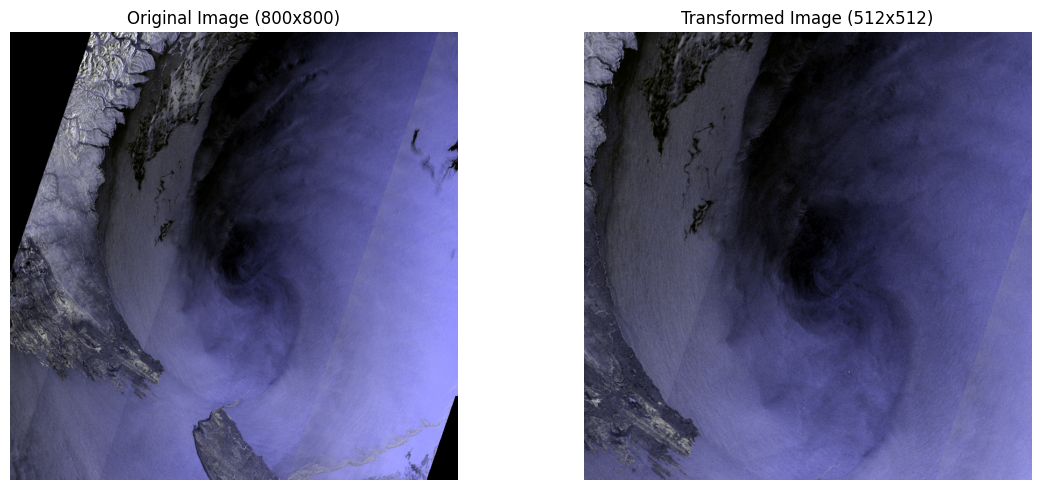

Batched image shape for model input: torch.Size([1, 3, 512, 512])
tensor([[1.5070e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [24]:
# Load sample image
image_path = Path(test_dir)/'pos'/'e8b0d4_20181231T025037_20181231T025219_mos_rgb.png'
image = get_image(image_path)

print(f"Original image size: {image.size}")

# Get the same transforms used for testing/inference
train_transform, test_transform = get_transforms()

# Apply the test transform (same as used during model evaluation)
transformed_image = test_transform(image)

print(f"Transformed image shape: {transformed_image.shape}")
print(f"Transformed image dtype: {transformed_image.dtype}")
print(f"Transformed image range: [{transformed_image.min():.3f}, {transformed_image.max():.3f}]")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original image
axes[0].imshow(image)
axes[0].set_title(f"Original Image ({image.size[0]}x{image.size[1]})")
axes[0].axis('off')

# Transformed image (convert tensor back to displayable format)
# PyTorch tensors are in CHW format, matplotlib expects HWC
transformed_display = transformed_image.permute(1, 2, 0)  # CHW -> HWC
axes[1].imshow(transformed_display)
axes[1].set_title(f"Transformed Image ({transformed_image.shape[1]}x{transformed_image.shape[2]})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# The transformed_image now ready to be fed to model
# It's a tensor with shape (3, 512, 512) and values in [0, 1]

# for model inference:
batched_image = transformed_image.unsqueeze(0)  # Shape: (1, 3, 512, 512)
print(f"Batched image shape for model input: {batched_image.shape}")

model.eval()
logits_sample_img = model(batched_image.to(device))
print(torch.softmax(logits_sample_img, dim=1)) 


Relevance Statistics:
  Positive contributing pixels: 132558
  Negative contributing pixels: 128699
  Max positive relevance: 0.078764
  Min negative relevance: -0.094544
Visualization saved to: explanation.png


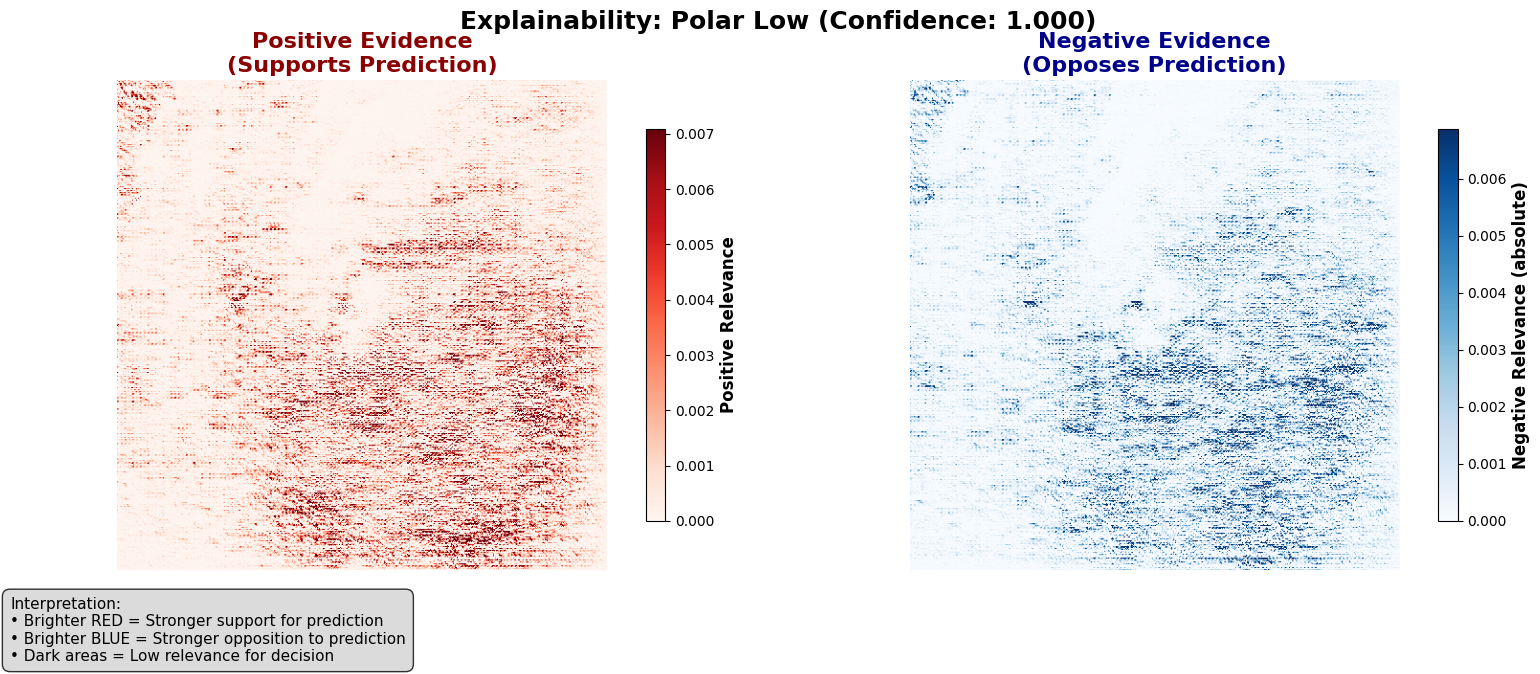

In [29]:
# Generate explanation
simple_lrp = SimpleLRPXception(model)
relevance = simple_lrp.explain(batched_image, method='integrated_gradients')

# Get prediction info
with torch.no_grad():
    logits = model(batched_image.to(device))
    predicted_class = logits.argmax(dim=1).item()
    confidence = torch.softmax(logits, dim=1)[0, predicted_class].item()

# Visualize with clear title
class_name = "Polar Low" if predicted_class == 1 else "Not Polar Low"
title = f"Explainability: {class_name} (Confidence: {confidence:.3f})"

visualize_relevance(relevance, title=title, save_path='explanation.png')